1/1 [==============================] - 0s 113ms/step


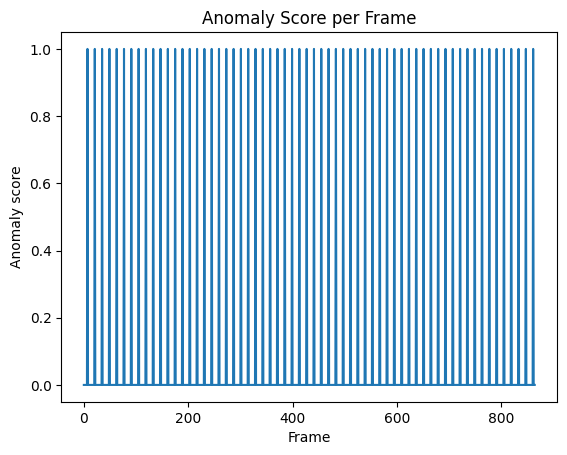

In [12]:
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import densenet121
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Load the pre-trained DenseNet 121 model
model = densenet121(pretrained=True)
model.eval()

# Define the transformation for resizing frames
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Load the anomaly detection model
anomaly_model = load_model('/Video_Anomaly_dectection_kaggle/Anomaly_detection/Trained_model/my_model_epoch_1.h5')

# Load the video
video_path = '/Khoa_hoc_dl_xu_ly_anh/Anomaly-Videos/Abuse/Abuse029_x264.mp4'
video = cv2.VideoCapture(video_path)

# Lists to store frame indices and anomaly scores
frame_indices = []
anomaly_scores = []

# Process each frame in the video
frame_index = 0
while True:
    # Read the next frame
    ret, frame = video.read()
    if not ret:
        break
    
    # Preprocess the frame
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_tensor = transform(frame)
    frame_tensor = frame_tensor.unsqueeze(0)
    
    # Pass the frame through the model
    with torch.no_grad():
        features = model.features(frame_tensor)
        output = torch.mean(features, dim=[2, 3])
    
    # Resize the frame tensor to match the anomaly model's input shape
    resized_frame_tensor = torch.nn.functional.interpolate(frame_tensor, size=(64, 64))
    
    # Transpose the dimensions of the resized frame tensor
    resized_frame_tensor = resized_frame_tensor.permute(0, 2, 3, 1)
    
    # Convert the resized frame tensor to numpy array
    resized_frame = resized_frame_tensor.numpy()
    
    # Make predictions using the anomaly detection model
    anomaly_score = anomaly_model.predict(resized_frame)
    
    # Reshape the anomaly score array
    anomaly_score = anomaly_score.reshape(-1)
    
    # Store the frame index and anomaly score
    frame_indices.append(frame_index)
    anomaly_scores.append(anomaly_score)
    
    frame_index += 1

# Concatenate the list of anomaly scores
anomaly_scores = np.concatenate(anomaly_scores)

# Truncate the anomaly_scores to match the length of frame_indices
anomaly_scores = anomaly_scores[:len(frame_indices)]

# Plot the anomaly scores
plt.plot(frame_indices, anomaly_scores)
plt.xlabel("Frame")
plt.ylabel("Anomaly score")
plt.title("Anomaly Score per Frame")
plt.show()